In [66]:
import os
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import Dataset
import glob
import matplotlib.pyplot as plt
import numpy as np
import scipy
import mne


In [67]:
data = r"/Users/josephthi/Desktop/UCI_Classes/cs184A/CS_184A_Final Project/data/spectrogram_data"

In [68]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [69]:
def append_data(path):
    X_data = []
    y_data = []
    for data in sorted(os.listdir(path)):
        file_path = os.path.join(path, data)
        if 'X' in data:
            X = np.load(file_path)
            X_data.append(X)
        elif 'y' in data:
            y = np.load(file_path)
            y_data.append(y)
        
    return X_data, y_data

In [70]:
X_data, y_data = append_data(r"data/spectrogram_data")
# X_data_n, y_data_n = append_data(r"data/noisy_spectrogram_data")

X_all_list = X_data 
y_all_list = y_data 

X = np.concatenate(X_all_list, axis = 0)
y = np.concatenate(y_all_list, axis = 0)

# --- Normalize inputs (global z-score) ---
# Spectrogram values are very small; normalize to zero-mean unit-variance
X_mean = X.mean()
X_std = X.std()
X = (X - X_mean) / (X_std + 1e-8)

print('After normalization: X mean {:.3e}, std {:.3e}'.format(X.mean(), X.std()))

After normalization: X mean -4.571e-19, std 1.419e-03


In [72]:
class EEGDataset(Dataset):
    def __init__(self, X, y):
        super(EEGDataset, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=y  # keeps class balance
)


train_dataset = EEGDataset(X_train, y_train)
test_dataset  = EEGDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=32, shuffle=False)

In [79]:
print(X.shape, y.shape)

(69705, 19, 33, 7) (69705,)


In [84]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model = model.to(device)


model.conv1 = nn.Conv2d(
    in_channels=19,
    out_channels=64,
    kernel_size=(7, 7),
    stride=(2, 2),
    padding=(3, 3),
    bias=False
).to(device)

model.fc = nn.Linear(model.fc.in_features, 3).to(device)


In [ ]:
'''
Calculate the weights
'''

alzheimer_weight = float(1672 / 684)
dementia_weight = float(1672 / 437)
healthy_weight = float(1672 / 551)

weights = torch.tensor([alzheimer_weight, dementia_weight, healthy_weight], dtype=torch.float32)

# Use class weights to mitigate class imbalance
weights = weights.to(device)
criterion = nn.CrossEntropyLoss(weight=weights)


In [90]:
num_epochs = 40
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [91]:
"""
Training Loop
"""
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}]  "
          f"Loss: {epoch_loss:.4f}  "
          f"Accuracy: {epoch_acc:.4f}")

/opt/anaconda3/envs/cs_184a_final/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (3) must match the size of tensor b (32) at non-singleton dimension 1

In [64]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 93.68%


Test Accuracy: 93.68%

Confusion Matrix:
 [[2935  290   86]
 [ 114 5603   99]
 [ 152  140 4522]]


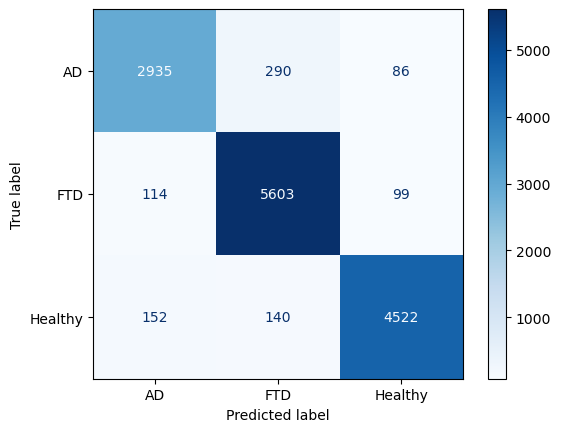

Classification Report:
               precision    recall  f1-score   support

          AD       0.92      0.89      0.90      3311
         FTD       0.93      0.96      0.95      5816
     Healthy       0.96      0.94      0.95      4814

    accuracy                           0.94     13941
   macro avg       0.94      0.93      0.93     13941
weighted avg       0.94      0.94      0.94     13941



In [65]:
# Make sure model is in evaluation mode
model.eval()

all_preds = []
all_labels = []

# Disable gradients for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.append(predicted.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Flatten lists
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# --- Accuracy ---
accuracy = (all_preds == all_labels).mean()
print(f"Test Accuracy: {accuracy*100:.2f}%\n")

# --- Confusion Matrix ---
class_names = ["AD", "FTD", "Healthy"]
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# --- Precision, Recall, F1 ---
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:\n", report)